In [444]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Franchises detection using BoxOfficeMojo and OMDBAPI

In this Notebook I visualized a Social Network of Actors, where two actors are linked if they starred together in more than a movie. It is a rough estimate of the existence of a franchise.

The data is based on the top 500 Grossing Movies according to BoxOfficeMojo. After having retrieved the titles from scraping BoxOfficeMojo, I used the OMDBAPI to retrieve data about the movies.

In [3]:
# Import requests package
import json
import pandas as pd
import requests
import re
import keyring
import networkx as nx
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
import numpy as np
from pyvis.network import Network
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [4]:
# Getting the top 500 grossing movies in the US 
results_titles = []
for i in range(1, 6):
    url = "https://www.boxofficemojo.com/alltime/domestic.htm?page=" + str(i) + "&p=.htm"
    r = requests.get(url)
    text = r.text
    soup = BeautifulSoup(text)
    b_tags = soup.find_all("b")
    results_titles_temp = list(map(lambda x: x.get_text(), b_tags))
    results_titles_temp = list(filter(lambda x: not x.startswith("$"), results_titles_temp))
    results_titles_temp = results_titles_temp[
        (results_titles_temp.index('Lifetime Gross')+1):(results_titles_temp.index('Lifetime Gross')+101)]
    results_titles.extend(results_titles_temp)
    
titles = results_titles.copy()

titles.remove("Marvel's The Avengers")
titles.append("The Avengers")
titles.remove("Dr. Seuss' The Lorax")
titles.append("The Lorax")
titles.remove("Monsters Vs. Aliens")
titles.append("Monsters vs. Aliens")
titles.remove("Dr. Seuss' Horton Hears a Who!")
titles.append("Horton Hears a Who!")
titles.remove("Marley and Me")
titles.append("Marley & Me")
titles.remove("Ocean's 8")
titles.append("Ocean's Eight")
titles.remove("Fantastic Four: Rise of the Silver Surfer")
titles.append("Fantastic 4: Rise of the Silver Surfer")
titles.remove("The Divergent Series: Insurgent")
titles.append("Insurgent")

In [5]:
pattern = re.compile(" \([0-9]+\)")
results_dict = {}
error_list = []
apikey = keyring.get_password('omdbapi', 'evergou')
for i in titles:
    if re.search(pattern, i):
        split_title = re.split('\(|\)', i)
        url = 'http://www.omdbapi.com/?apikey=' + apikey + '&t=' + split_title[0].replace(" ", "+") + \
        '&y=' + split_title[1]
    else:
        url = 'http://www.omdbapi.com/?apikey=' + apikey + '&t=' + i.replace(" ", "+")
    r = requests.get(url)
    json_data = r.json()
    try:
        results_dict[json_data["imdbID"]] = json_data
    except:
        error_list.append(i)

Here is an example of how an entry from the OMDBAPI looks like.

In [6]:
results_dict['tt2771200']

{'Actors': 'Emma Watson, Dan Stevens, Luke Evans, Josh Gad',
 'Awards': 'Nominated for 2 Oscars. Another 12 wins & 65 nominations.',
 'BoxOffice': '$503,974,884',
 'Country': 'USA',
 'DVD': '06 Jun 2017',
 'Director': 'Bill Condon',
 'Genre': 'Family, Fantasy, Musical, Romance',
 'Language': 'English',
 'Metascore': '65',
 'Plot': 'A selfish prince is cursed to become a monster for the rest of his life, unless he learns to fall in love with a beautiful young woman he keeps prisoner.',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BMTUwNjUxMTM4NV5BMl5BanBnXkFtZTgwODExMDQzMTI@._V1_SX300.jpg',
 'Production': 'Walt Disney Pictures',
 'Rated': 'PG',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '7.2/10'},
  {'Source': 'Rotten Tomatoes', 'Value': '71%'},
  {'Source': 'Metacritic', 'Value': '65/100'}],
 'Released': '17 Mar 2017',
 'Response': 'True',
 'Runtime': '129 min',
 'Title': 'Beauty and the Beast',
 'Type': 'movie',
 'Website': 'http://movies.disney.com/beauty-and-t

In [82]:
results_copy = results_dict.copy()
results_df = pd.DataFrame.from_dict(results_copy).T
actors_df = results_df.Actors.str.split(",", expand=True).reset_index().rename(columns={"index":"imdbID"})
actors_df = actors_df.merge(results_df.imdbRating, how = "left", right_index=True, left_on = 'imdbID')
actors_df = pd.melt(actors_df, id_vars=["imdbID", "imdbRating"], value_vars=[0,1,2,3], value_name="Actor").drop('variable', 1)
actors_df.Actor.replace("None", np.nan, inplace=True)
actors_df["Actor"] = actors_df.Actor.str.strip()
actors_df['imdbRating'] = actors_df.imdbRating.astype(float)
actors_edge = actors_df.merge(actors_df, how="left", on='imdbID', suffixes=("_1", "_2"))
actors_edge = actors_edge[actors_edge.Actor_1!=actors_edge.Actor_2]
actors_edge["weight"] = 1

In [83]:
actors_avg_imbd_score = actors_df.groupby('Actor').imdbRating.mean()

actors_edge_with_weights = actors_edge.groupby(
    ['Actor_1', 'Actor_2']).weight.sum().reset_index().sort_values('weight', ascending=False)

actors_edge_weights_imdb_score = actors_edge_with_weights.merge(actors_avg_imbd_score, how='left', left_on = 'Actor_1',
                                                               right_index=True)

actors_edge_weights_imdb_score = actors_edge_weights_imdb_score.merge(actors_avg_imbd_score, how='left', left_on = 'Actor_2',
                                                               right_index=True, suffixes=('_1','_2'))

In [84]:
actors_edge_weights_imdb_score_more_than_1 = actors_edge_weights_imdb_score[actors_edge_weights_imdb_score['weight']>1]

In [85]:
sources = actors_edge_weights_imdb_score['Actor_1']
targets = actors_edge_weights_imdb_score['Actor_2']
weights = actors_edge_weights_imdb_score['weight']
edge_data = list(zip(sources, targets, weights))

sources_m_t_1 = actors_edge_weights_imdb_score_more_than_1['Actor_1']
targets_m_t_1 = actors_edge_weights_imdb_score_more_than_1['Actor_2']
weights_m_t_1 = actors_edge_weights_imdb_score_more_than_1['weight']
edge_data_m_t_1 = list(zip(sources_m_t_1, targets_m_t_1, weights_m_t_1))

In [86]:
G = nx.Graph()
for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    G.add_node(src)
    G.add_node(dst)
    G.add_edge(src, dst, value=w)
    
G_m_t_1 = nx.Graph()
for e in edge_data_m_t_1:
    src = e[0]
    dst = e[1]
    w = e[2]

    G_m_t_1.add_node(src)
    G_m_t_1.add_node(dst)
    G_m_t_1.add_edge(src, dst, value=w)

Some caveats: the OMBDAPI returns only four actors per movie, the full cast is not available.

We can see here the top 10 actors by centrality.

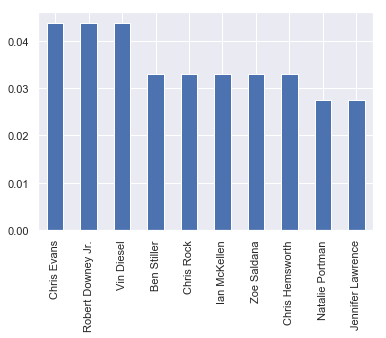

In [103]:
pd.Series(nx.degree_centrality(G_m_t_1)).T.sort_values(ascending=False)[:10].plot(kind="bar")
plt.show()

In [87]:
actors_edge_weights_imdb_score_centrality = actors_edge_weights_imdb_score.merge(
    pd.Series(nx.degree_centrality(G)).T.rename('centrality'), right_index=True, left_on='Actor_1')

actors_edge_weights_imdb_score_centrality = actors_edge_weights_imdb_score_centrality.merge(
    pd.Series(nx.degree_centrality(G)).T.rename('centrality'), right_index=True, left_on='Actor_2',
suffixes=('_1', '_2'))

actors_edge_weights_imdb_score_centrality_more_than_1 = actors_edge_weights_imdb_score_more_than_1.merge(
    pd.Series(nx.degree_centrality(G_m_t_1)).T.rename('centrality'), right_index=True, left_on='Actor_1')

actors_edge_weights_imdb_score_centrality_more_than_1 = actors_edge_weights_imdb_score_centrality_more_than_1.merge(
    pd.Series(nx.degree_centrality(G_m_t_1)).T.rename('centrality'), right_index=True, left_on='Actor_2',
suffixes=('_1', '_2'))

In [78]:
sources = actors_edge_weights_imdb_score_centrality['Actor_1']
targets = actors_edge_weights_imdb_score_centrality['Actor_2']
weights = actors_edge_weights_imdb_score_centrality['weight']
size_1 = actors_edge_weights_imdb_score_centrality['centrality_1']*100000
size_2 = actors_edge_weights_imdb_score_centrality['centrality_2']*100000

edge_data = list(zip(sources, targets, weights, size_1, size_2))

In [79]:
net = Network(height="750px", width="100%", bgcolor="#7e8580", font_color="white")
net.force_atlas_2based()

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    src_s = e[3]
    dst_s = e[4]

    net.add_node(src, src, value=src_s, title=src)
    net.add_node(dst, dst, value=dst_s, title=dst)
    net.add_edge(src, dst, value=w)

net.show_buttons(filter_=['physics'])

In [80]:
net.show("actors_network_2.html")

In [100]:
sources = actors_edge_weights_imdb_score_centrality_more_than_1['Actor_1']
targets = actors_edge_weights_imdb_score_centrality_more_than_1['Actor_2']
weights = actors_edge_weights_imdb_score_centrality_more_than_1['weight']
size_1 = actors_edge_weights_imdb_score_centrality_more_than_1['centrality_1']
size_2 = actors_edge_weights_imdb_score_centrality_more_than_1['centrality_2']
edge_data = list(zip(sources, targets, weights, size_1, size_2))

In [101]:
net = Network(height="750px", width="100%", bgcolor="#7e8580", font_color="white", notebook=True)
net.force_atlas_2based()

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    src_s = e[3]
    dst_s = e[4]

    net.add_node(src, src, value=src_s, title=src)
    net.add_node(dst, dst, value=dst_s, title=dst)
    net.add_edge(src, dst, value=w)

net.show_buttons(filter_=['physics'])

Here is the network.

The size of the bubble is the Centrality, while the more movies the Actors starred together in, the heavier the edge.

See how many franchises you can identify!

In [102]:
net.show("actors_network_more_than_1.html")